In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, Embedding, LSTM, Concatenate)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix


In [24]:
# Load Dataset
data = pd.read_csv("Dataset/labels.csv")

# Encode sentiment labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2, 'very_negative': 3, 'very_positive': 4}
data['enc_label'] = data['overall_sentiment'].map(label_map)

# Split Train and Test
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['enc_label'], random_state=42)
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Train shape: (5593, 6)
Test shape: (1399, 6)


In [25]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import os

# Image Paths
image_dir = "Dataset/images/images"
train_paths = [os.path.join(image_dir, name) for name in train_data['image_name']]
test_paths = [os.path.join(image_dir, name) for name in test_data['image_name']]

# Load & Preprocess images
def load_images(image_paths):
    images = []
    for path in image_paths:
        try:
            img = load_img(path, target_size=(224, 224))
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
        except:
            continue
    return np.array(images)

X_train_img = load_images(train_paths)
X_test_img = load_images(test_paths)

print("Train Image shape:", X_train_img.shape)
print("Test Image shape:", X_test_img.shape)

# Load Pretrained ResNet50 Model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_output = GlobalAveragePooling2D()(resnet_model.output)
resnet_feature_model = Model(inputs=resnet_model.input, outputs=resnet_output)

# Extract Image Embeddings
resnet_train_embed = resnet_feature_model.predict(X_train_img, batch_size=32, verbose=1)
resnet_test_embed = resnet_feature_model.predict(X_test_img, batch_size=32, verbose=1)

print("ResNet Embedding shapes:", resnet_train_embed.shape, resnet_test_embed.shape)


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Image shape: (5592, 224, 224, 3)
Test Image shape: (1399, 224, 224, 3)
175/175 ━━━━━━━━━━━━━━━━━━━━ 110s 618ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 580ms/step
ResNet Embedding shapes: (5592, 2048) (1399, 2048)


In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Build CNN Model
def build_cnn_model():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.3))
    return cnn

cnn_model = build_cnn_model()

# Extract CNN Features
cnn_input = Input(shape=(224, 224, 3))
cnn_features = cnn_model(cnn_input)
cnn_feature_model = Model(inputs=cnn_input, outputs=cnn_features)

cnn_train_embed = cnn_feature_model.predict(X_train_img, batch_size=32, verbose=1)
cnn_test_embed = cnn_feature_model.predict(X_test_img, batch_size=32, verbose=1)

print("CNN Embedding shapes:", cnn_train_embed.shape, cnn_test_embed.shape)


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
CNN Embedding shapes: (5592, 256) (1399, 256)


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Drop missing text rows & ensure text is string
train_data = train_data.dropna(subset=['text_corrected'])
test_data = test_data.dropna(subset=['text_corrected'])
train_data['text_corrected'] = train_data['text_corrected'].astype(str)
test_data['text_corrected'] = test_data['text_corrected'].astype(str)

# Tokenizer Function
def text_tokenizer(train_data, test_data, vocabulary, max_len):
    tokenizer = Tokenizer(num_words=vocabulary, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_data['text_corrected'])
    
    train_seq = tokenizer.texts_to_sequences(train_data['text_corrected'])
    train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post')
    
    test_seq = tokenizer.texts_to_sequences(test_data['text_corrected'])
    test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post')
    
    vocab_size = len(tokenizer.word_index) + 1
    return train_pad, test_pad, vocab_size, tokenizer.word_index

# Parameters
vocabulary = 15000
max_len = 60

# Apply Tokenizer
train_pad_seq, test_pad_seq, vocab_size, word_index = text_tokenizer(train_data, test_data, vocabulary, max_len)

print("Train text shape:", train_pad_seq.shape)
print("Test text shape:", test_pad_seq.shape)
print("Vocab size:", vocab_size)


Train text shape: (5588, 60)
Test text shape: (1399, 60)
Vocab size: 11583


In [28]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.models import Model

# Define Inputs
resnet_input = Input(shape=(2048,))  # ResNet embedding shape
cnn_input = Input(shape=(256,))      # CNN embedding shape
text_input = Input(shape=(60,))      # Padded sequence length

# Text Embedding + LSTM
text_embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=60)(text_input)
text_lstm = LSTM(128)(text_embedding)

# Concatenate All
fusion = Concatenate()([resnet_input, cnn_input, text_lstm])
x = Dense(256, activation='relu')(fusion)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

# Model
multi_modal_model = Model(inputs=[resnet_input, cnn_input, text_input], outputs=output)
multi_modal_model.summary()

# Compile
multi_modal_model.compile(loss='sparse_categorical_crossentropy',
                          optimizer=RMSprop(learning_rate=1e-4),
                          metrics=['accuracy'])


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 60, 128)   │  1,482,624 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2432)      │          0 │ input_layer_13[0… │
│ (Concatenate)       │                   │            │ input_layer_14[0… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    622,848 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5)         │      1,285 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,238,341 (8.54 MB)

 Trainable params: 2,238,341 (8.54 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Align data - Drop NaNs in text and keep corresponding images
train_data_clean = train_data.dropna(subset=['text_corrected']).reset_index(drop=True)
test_data_clean = test_data.dropna(subset=['text_corrected']).reset_index(drop=True)

# Prepare inputs again
y_train = train_data_clean['enc_label'].values
y_test = test_data_clean['enc_label'].values

# Filter embeddings
resnet_train_embed_clean = resnet_train_embed[:len(train_data_clean)]
cnn_train_embed_clean = cnn_train_embed[:len(train_data_clean)]
train_pad_seq_clean = train_pad_seq[:len(train_data_clean)]

resnet_test_embed_clean = resnet_test_embed[:len(test_data_clean)]
cnn_test_embed_clean = cnn_test_embed[:len(test_data_clean)]
test_pad_seq_clean = test_pad_seq[:len(test_data_clean)]

# Train Model
history = multi_modal_model.fit([resnet_train_embed_clean, cnn_train_embed_clean, train_pad_seq_clean],
                                y_train,
                                epochs=10,
                                batch_size=32,
                                validation_split=0.1,
                                verbose=1)

# Evaluate on Test
loss, acc = multi_modal_model.evaluate([resnet_test_embed_clean, cnn_test_embed_clean, test_pad_seq_clean], y_test, verbose=1)
print(f"\nTest Accuracy: {acc:.4f}")


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3861 - loss: 1.5898 - val_accuracy: 0.4186 - val_loss: 1.3809
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4190 - loss: 1.3478 - val_accuracy: 0.4186 - val_loss: 1.3757
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4404 - loss: 1.2929 - val_accuracy: 0.4275 - val_loss: 1.3524
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4598 - loss: 1.2469 - val_accuracy: 0.4132 - val_loss: 1.3632
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4698 - loss: 1.2302 - val_accuracy: 0.4329 - val_loss: 1.3949
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5080 - loss: 1.1905 - val_accuracy: 0.3846 - val_loss: 1.3945
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5179 - loss: 1.1527 - val_accuracy: 0.3900 - val_loss: 1.4007
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5352 - loss: 1.1148 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.34      0.29      0.31       440
           2       0.46      0.73      0.56       626
           3       0.00      0.00      0.00        30
           4       0.18      0.02      0.03       207

    accuracy                           0.42      1399
   macro avg       0.20      0.21      0.18      1399
weighted avg       0.34      0.42      0.36      1399



c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

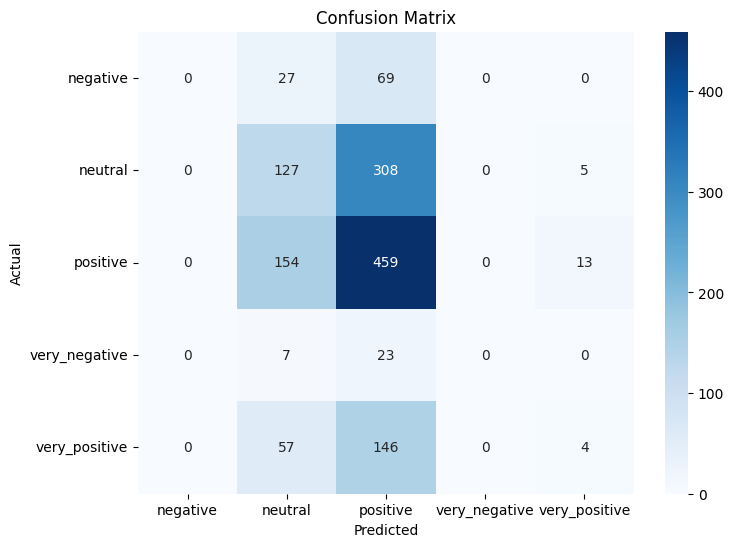

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = multi_modal_model.predict([resnet_test_embed, cnn_test_embed, test_pad_seq])
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
